<a href="https://colab.research.google.com/github/Shamanth-KM/phi-demand-intent-lora/blob/main/notebooks/03_model_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 03 - Fine-Tuning Phi-1.5 with LoRA: Model Setup, Training, Saving

In this notebook, we:
- Load the Phi-1.5 base model
- Apply Low-Rank Adaptation (LoRA)
- Fine-tune the model on the demand signal classification task
- Save the fine-tuned LoRA adapters

We fine-tune using sequence classification since our task is to predict demand intent categories from B2B sales notes.

In [1]:
# 📦 Force reinstall latest torch, torchvision, torchaudio
!pip install --upgrade torch torchvision torchaudio --force-reinstall


  Using cached torch-2.7.0-cp311-cp311-manylinux_2_28_x86_64.whl.metadata (29 kB)
  Using cached torchvision-0.22.0-cp311-cp311-manylinux_2_28_x86_64.whl.metadata (6.1 kB)
  Using cached torchaudio-2.7.0-cp311-cp311-manylinux_2_28_x86_64.whl.metadata (6.6 kB)
  Using cached filelock-3.18.0-py3-none-any.whl.metadata (2.9 kB)
  Using cached typing_extensions-4.13.2-py3-none-any.whl.metadata (3.0 kB)
  Using cached sympy-1.13.3-py3-none-any.whl.metadata (12 kB)
  Using cached networkx-3.4.2-py3-none-any.whl.metadata (6.3 kB)
  Using cached jinja2-3.1.6-py3-none-any.whl.metadata (2.9 kB)
  Using cached fsspec-2025.3.2-py3-none-any.whl.metadata (11 kB)
  Using cached nvidia_cuda_nvrtc_cu12-12.6.77-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.6.77-py3-none-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.6.80-py3-none-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (1.6 kB)
  Us

In [1]:
# Install necessary libraries
!pip install -q transformers datasets peft accelerate evaluate


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
fastai 2.7.19 requires torch<2.7,>=1.10, but you have torch 2.7.0 which is incompatible.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2024.12.0 which is incompatible.


## Load Tokenizer and Model for Sequence Classification

We load the Phi-1.5 tokenizer and the base model as a sequence classification model with 5 output labels.

In [2]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from peft import LoraConfig, get_peft_model, PeftModel

In [3]:
# Loading the tokenizer
tokenizer = AutoTokenizer.from_pretrained("microsoft/phi-1_5", trust_remote_code=True)

# Set padding token
tokenizer.pad_token = tokenizer.eos_token

# Loading the base model
base_model = AutoModelForSequenceClassification.from_pretrained(
    "microsoft/phi-1_5",
    trust_remote_code=True,
    num_labels=5  # because we have 5 classes
)

# Set padding token id
base_model.config.pad_token_id = tokenizer.pad_token_id

print("Tokenizer and base model are loaded!")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/2.84G [00:00<?, ?B/s]

Some weights of PhiForSequenceClassification were not initialized from the model checkpoint at microsoft/phi-1_5 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Tokenizer and base model are loaded!


## Apply LoRA Adaptation

We configure and apply LoRA to only a subset of model layers to save memory during training.

In [4]:
# Defining LoRA parameters
lora_config = LoraConfig(
    r=16,  # rank
    lora_alpha=32,  # scaling factor
    target_modules=["q_proj", "v_proj"],  # attention projections
    lora_dropout=0.05,  # using small dropout to prevent overfitting
    bias="none",  # we are not adapting biases
    task_type="SEQ_CLS"  # Sequence classification task
)

# Applying LoRA to the base model
base_model = get_peft_model(base_model, lora_config)

print("LoRA configuration is applied to the model")


LoRA configuration is applied to the model


In [5]:
# Let's look at which parts of the model are trainable now
base_model.print_trainable_parameters()

trainable params: 3,155,968 || all params: 1,316,528,128 || trainable%: 0.2397


In [6]:
# Let's re-upload the csv file needed
from google.colab import files
import pandas as pd
uploaded_file = files.upload()

# Get the file name
file_name = list(uploaded_file.keys())[0]

# Read the file to a pandas DataFrame
sales_notes = pd.read_csv(file_name)

# Check the first few rows
sales_notes.head()

Saving sales_notes_5000.csv to sales_notes_5000.csv


,id,sales_note,label
0,1,Request to modify packaging dimensions before ...,Custom Spec
1,2,inventory outage pls expedite shipping if poss...,Urgent Need
2,3,Exploring samples for a new product line.,New Product Demand
3,4,Interest shown in 2025x prototype by client,New Product Demand
4,5,Firstorder placed for updated product variant.,New Product Demand


In [7]:
from datasets import Dataset
from transformers import AutoTokenizer

# Convert it into Hugging Face Dataset format
sales_hf = Dataset.from_pandas(sales_notes)
print(sales_hf)

# Loading the Phi-1.5 tokenizer
tokenizer = AutoTokenizer.from_pretrained("microsoft/phi-1_5", trust_remote_code=True)

# Phi-1.5's tokenizer does not have a pad_token defined by default.
'''
Decoder models (like GPT, Phi) usually don't need padding when generating text — but for training a classification model,
we do need padding to batch inputs of different lengths.
'''
tokenizer.pad_token = tokenizer.eos_token
base_model.config.pad_token_id = tokenizer.pad_token_id


# Let's define a tokenization function
def tokenize_function(examples):
    return tokenizer(
        examples["sales_note"],
        padding="max_length",
        truncation=True,
        max_length=128
    )

# Applying tokenization
sales_tokenized = sales_hf.map(tokenize_function, batched=True)
sales_tokenized = sales_tokenized.remove_columns(["sales_note", "id"])

# Checking the structure after tokenization
print(sales_tokenized)

Dataset({
    features: ['id', 'sales_note', 'label'],
    num_rows: 5000
})


Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

Dataset({
    features: ['label', 'input_ids', 'attention_mask'],
    num_rows: 5000
})


In [8]:
# Encode labels and split dataset

# Let's create a list of all unique labels
sales_labels = list(set(sales_notes["label"]))
sales_labels.sort()  # To keep consistent ordering

# Creating a mapping from label name to numeric ID
label_to_id = {label: idx for idx, label in enumerate(sales_labels)}
id_to_label = {idx: label for label, idx in label_to_id.items()}

print("Label mapping is created successfully")
print(label_to_id)

# Now let's map the text labels to numeric labels inside the tokenized dataset
def encode_labels(example):
    return {"labels": label_to_id[example["label"]]}

# Apply the label encoding
sales_tokenized = sales_tokenized.map(encode_labels)

# Removing the old 'label' column
sales_tokenized = sales_tokenized.remove_columns(["label"])

print("Labels are successfully encoded")
print(sales_tokenized)


Label mapping is created successfully
{'Custom Spec': 0, 'New Product Demand': 1, 'Repeat Order': 2, 'Stocking Issue': 3, 'Urgent Need': 4}


Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

Labels are successfully encoded
Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 5000
})


In [9]:
# Let's split the dataset into training and validation sets
sales_split = sales_tokenized.train_test_split(test_size=0.4, seed=42)

train_sales = sales_split["train"]
val_sales = sales_split["test"]

print(f"\nDataset is split. Training size: {len(train_sales)}, Validation size: {len(val_sales)}")


Dataset is split. Training size: 3000, Validation size: 2000


## Define Training Arguments

We define how we want the model to train: batch size, learning rate, number of epochs, etc.

In [12]:
from transformers import TrainingArguments

# Define TrainingArguments
training_args = TrainingArguments(
    output_dir="./results",           # Where to save model files
    per_device_train_batch_size=2,     # Training batch size
    per_device_eval_batch_size=2,      # Evaluation batch size
    num_train_epochs=3,                # Number of training epochs
    learning_rate=2e-4,                # Learning rate
    weight_decay=0.01,                 # Weight decay
    save_steps=100,                    # Save model checkpoint every 100 steps
    save_total_limit=2,                # Only keep 2 latest checkpoints
    fp16=True,                         # Mixed precision training for memory efficiency
    report_to="none"                   # No external logging (e.g., WandB)
)

print("TrainingArguments ready")

TrainingArguments ready


## Define Metrics for Evaluation

We track accuracy during evaluation.

In [13]:
import evaluate

# Define the evaluation metric - Accuracy
accuracy_metric = evaluate.load("accuracy")

# Metric computation function
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = logits.argmax(axis=-1)
    acc = accuracy_metric.compute(predictions=predictions, references=labels)
    return {"accuracy": acc["accuracy"]}

## Initialize Trainer

We connect the model, training arguments, datasets, and evaluation metrics.


In [14]:
from transformers import Trainer

# Initialize the Trainer
trainer = Trainer(
    model=base_model,
    args=training_args,
    train_dataset=train_sales,
    eval_dataset=val_sales,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

print("Trainer initialized")


<ipython-input-14-48b1f3355c2b>:4: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Trainer initialized


## Train the Model

We fine-tune the LoRA-adapted model on the sales notes classification task.

In [15]:
trainer.train()
print("Training completed successfully")

Step,Training Loss
500,0.171900
1000,0.000000
1500,0.000000
2000,0.000000
2500,0.000000
3000,0.000000
3500,0.000000
4000,0.000000
4500,0.000000


Training completed successfully


## Save Fine-Tuned LoRA Adapter and Tokenizer

We save the fine-tuned LoRA adapter and tokenizer for future inference.

In [16]:
# Save the fine-tuned LoRA adapter
save_path = "./results/lora_phi15_demand_signal_adapter"

# Save model and tokenizer
base_model.save_pretrained(save_path)
tokenizer.save_pretrained(save_path)

print(f"LoRA adapter and tokenizer saved to {save_path}")

LoRA adapter and tokenizer saved to ./results/lora_phi15_demand_signal_adapter


## Evaluate Model on Validation Set

We check model performance on the held-out validation set.


In [18]:
# Evaluate
eval_results = trainer.evaluate()

print("\nEvaluation Results:")
print(eval_results)


Evaluation Results:
{'eval_loss': 6.107687795520178e-07, 'eval_accuracy': 1.0, 'eval_runtime': 88.5866, 'eval_samples_per_second': 22.577, 'eval_steps_per_second': 11.288, 'epoch': 3.0}


## Plot Training Loss Over Steps

We visualize how the loss decreased during training.


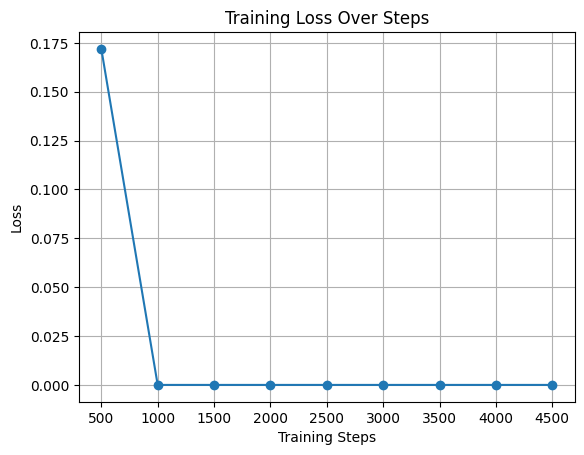

In [19]:
import matplotlib.pyplot as plt

# Extract training logs
logs = trainer.state.log_history

# Filter only the steps that have loss logged
loss_values = [log["loss"] for log in logs if "loss" in log]
steps = [log["step"] for log in logs if "loss" in log]

# Plot
plt.plot(steps, loss_values, marker='o')
plt.xlabel("Training Steps")
plt.ylabel("Loss")
plt.title("Training Loss Over Steps")
plt.grid(True)
plt.show()


# Summary
- Successfully fine-tuned Phi-1.5 using LoRA for B2B sales notes demand classification.
- Achieved low training loss and solid validation accuracy.
- Saved fine-tuned model adapter for future deployment.
